<a href="https://colab.research.google.com/github/CPJKU/partitura_tutorial/blob/main/content/Partitura_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to Symbolic Music Processing with Partitura

Partitura is python 3 package for symbolic music processing developed and maintained at OFAI Vienna / CP JKU Linz (and other contributors). It's inteded to give a lightweight musical part representation that makes many score properties easily accessible for a variety of tasks. Furthermore it's a very useful I/O utility to parse computer formats of symbolic music. 

## 1. Install and import

Partitura is available in github https://github.com/CPJKU/partitura

You can install it with `pip install partitura`.

However if you are interested in features that still have to be officially released, it's better to install the develop branch.

In [55]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # Install partitura
    ! pip install git+https://github.com/CPJKU/partitura.git@develop

    # To be able to access helper modules in the repo for this tutorial
    # (not necessary if the jupyter notebook is run locally instead of google colab)
    !git clone https://github.com/CPJKU/partitura_tutorial.git
else:
    pass

In [56]:
import glob
import os

import partitura as pt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import IPython.display as ipd

#### Dataset for this tutorial

In this tutorial we are going to use the [Vienna 4x22 Corpus](https://repo.mdw.ac.at/projects/IWK/the_vienna_4x22_piano_corpus/index.html) which consists of performances of 4 classical piano pieces, which have been aligned to their corresponding scores.

The dataset contains:

* Scores in MusicXML format (4 scores)
* Performances in MIDI files (88 in total, 22 performances per piece, each by a different pianist)
* Score to performance alignments in Match file format (88 in total one file per performance)

In [57]:
# setup the dataset
from load_data import init_dataset
DATASET_DIR = init_dataset()
MUSICXML_DIR = os.path.join(DATASET_DIR, 'musicxml')
MIDI_DIR = os.path.join(DATASET_DIR, 'midi')
MATCH_DIR = os.path.join(DATASET_DIR, 'match')

Output()

## 2. Loading and Exporting Files

One of the main use cases of partitura is to load and export common symbolic music formats.

### Supported Formats

#### Reading

##### Symbolic Scores

These methods return `Score` objects.

|Format| Method|Notes|
|:---|:---|:---|
|MusicXML| `partitura.load_musicxml`| |
|MIDI| `partitura.load_score_midi`|Pitch spelling, key signature (optional) and other information is inferred with methods in `partitura.musicanalysis`. 
|MEI| `partitura.load_mei`|
|Humdrum Kern| `partitura.load_kern`|
|MuseScore|`partitura.load_via_musescore`| Requires [MuseScore](https://musescore.org/en). Loads all formats supported by MuseScore. Support on Windows is still untested.

##### Symbolic Performances

These methods return a `Performance`.

|Format| Method|Notes|
|:---|:---|:---|
|MIDI|`partitura.load_performance_midi`| Loads MIDI file as a performance, including track, channel and program information. Time signature and tempo information are only used to compute the time of the MIDI messages in seconds. Key signature information is ignored

##### Alignments

These methods return score-to-performance alignments (discussed in another notebook).

|Format| Method|Notes|
|:---|:---|:---|
|Match file| `partitura.load_match`| Returns alignment, a performance as `PerformedPart` and optionally a `Part`. See usage below.
|Nakamura et al. corresp file | `partitura.load_nakamuracorresp`|
|Nakamura et al. match file| `partitura.load_nakamuramatch`|

#### Writing

##### Symbolic Scores

|Format| Method|Notes|
|:---|:---|:---|
|MusicXML| `partitura.save_musicxml`|
|MIDI| `partitura.save_score_midi`| Includes Key signature, time signature and tempo information.

##### Symbolic Performances
|Format| Method|Notes|
|:---|:---|:---|
|MIDI|`partitura.save_performance_midi`| Does not include key signature or time signature information

##### Alignments

|Format| Method|Notes|
|:---|:---|:---|
|Match file| `partitura.save_match`| 


## 3. Internal Representations

### 3.0 The Score Object

Score loading functions return a ```Score``` object. It's a wrapper storing score metadata such as composer and piece as well as all musical material in the score. At the same time it acts as an iterator of contained  ```Part``` objects.

### 3.1 The Part Object

The ```Part``` object is the central object of partitura. Its name stems from musicxml parts and usually a single instrument.
- it is a timeline object
- time is measured in divs
- its elements are timed objects, i.e. they have a starting time and an ending time
- external score files are loaded into a part
- parts can be exported into score files
- it contains many useful methods related to its properties

Here's a visual representation of the ```Part``` object representing the first measure of Chopin's Nocturne Op. 9 No. 2

![Timeline_chopin2.png](https://github.com/CPJKU/partitura_tutorial/raw/main/static/Timeline_chopin2.png)

In [58]:
path_to_musicxml = pt.EXAMPLE_MUSICXML
part = pt.load_musicxml(path_to_musicxml)[0] # we access the first (and sole) part of this score by indexing the returned score
print(part.pretty())

Part id="P1" name="Piano"
 │
 ├─ TimePoint t=0 quarter=12
 │   │
 │   └─ starting objects
 │       │
 │       ├─ 0--48 Measure number=1
 │       ├─ 0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
 │       ├─ 0--48 Page number=1
 │       ├─ 0--24 Rest id=r01 voice=2 staff=1 type=half
 │       ├─ 0--48 System number=1
 │       └─ 0-- TimeSignature 4/4
 │
 ├─ TimePoint t=24 quarter=12
 │   │
 │   ├─ ending objects
 │   │   │
 │   │   └─ 0--24 Rest id=r01 voice=2 staff=1 type=half
 │   │
 │   └─ starting objects
 │       │
 │       ├─ 24--48 Note id=n02 voice=2 staff=1 type=half pitch=C5
 │       └─ 24--48 Note id=n03 voice=2 staff=1 type=half pitch=E5
 │
 └─ TimePoint t=48 quarter=12
     │
     └─ ending objects
         │
         ├─ 0--48 Measure number=1
         ├─ 0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
         ├─ 24--48 Note id=n02 voice=2 staff=1 type=half pitch=C5
         ├─ 24--48 Note id=n03 voice=2 staff=1 type=half pitch=E5
         ├─ 0--48 Page number=

![score_example.png](https://github.com/CPJKU/partitura_tutorial/raw/main/static/score_example.png)

### 3.2 Notes

Each ```Part``` object contains a list notes. Notes inherit from the ```TimedObject``` class. Like all ```TimedObjects``` they contain a (possibly coincident) start time and end time, encoded as ```TimePoint``` objects.

In [59]:
part.notes

In [60]:
# uncomment to print all note object attributes
# dir(part.notes[0])

You can create notes (without timing information) and then add it to a part by specifying start and end times (in divs!). Use each note object only once! You can remove notes from a part.

In [61]:
a_new_note = pt.score.Note(id='n04', step='A', octave=4, voice=1)
part.add(a_new_note, start=3, end=15)
# print(part.pretty())

In [62]:
part.remove(a_new_note)
# print(part.pretty())

### 3.3 Converting from divs to musical units and back

Integer divs are useful for encoding scores but unwieldy for human readers. Partitura offers a variety of ```*unit*_maps``` from the timeline unit "div" to musical units such as "beats" (in two different readings) or "quarters". For the inverse operation the corresponding ```inv_*unit*_map``` exist as well. Quarter to div ratio is a fixed value for a ```Part``` object, but units like beats might change with time signature, so these ```maps``` are implemented as ```Part``` methods.

Let's look at how to get the ending position in beats of the last note in our example ```Part```.

In [63]:
part.beat_map(part.notes[0].end.t)

array(4.)

### Timeline maps

For several TimedObjects partitura offers convenient ```maps``` that return the object at a position, usually given in divs. Other musical information such as key and time signature is valid for a segment of the score but only encoded in one location. ```Maps``` also retrieve the "currently active" time or key signature at any score position.

|Returns| Method|Notes|
|:---|:---|:---|
|Time Signature | `part.time_signature_map`|return a triple of beats, beat_type, and musical_beats|
|Key Signature | `part.key_signature_map`||
|Measure |  `part.measure_map`| returns the start and end point of the current measure |
|Measure Number|  `part.measure_number_map`||
|Metrical Position|  `part.metrical_position_map`||
|Divs -> Beat|  `part.beat_map`||
|Beat -> Divs|  `part.inv_beat_map`||
|Divs -> Quarters|  `part.quarter_map`||
|Quarter -> Divs|  `part.inv_quarter_map`||
|Quarter Durations|  `part.quarter_duration_map`||


### 3.4 Iterating over arbitrary musical objects in a part

Each ```Part``` object contains a central method ```iter_all``` to iterate over all instances of the ```TimedObject``` class or its subclasses of a part. The ```iter_all``` method returns an iterator and takes five optional parameters: 
- A ```TimedObject``` subclass whose instances are returned. You can find them all in the partitura/partitura/score.py file. Default is all classes.
- A ```include_subclasses``` flag. If true, instances of subclasses are returned too. E.g. ``` part.iter_all(pt.score.TimedObject, include_subclasses=True)``` returns all objects or ```part.iter_all(pt.score.GenericNote, include_subclasses=True)``` returns all notes (grace notes, standard notes)
- A start time in divs to specify the search interval (default is beginning of the part)
- An end time in divs to specify the search interval (default is end of the part)
- A ```mode``` parameter to define whether to search for starting or ending objects, defaults to starting.

In [64]:
for measure in part.iter_all(pt.score.Measure):
    print(measure)

0--48 Measure number=1


In [65]:
for note in part.iter_all(pt.score.GenericNote, include_subclasses=True, start=0, end=24):
    print(note)

0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
0--24 Rest id=r01 voice=2 staff=1 type=half


### 3.5 TimedObject list retrieval

For several TimedObjects partitura offers convenient retrieval functions that return the a list of that object without having to use the general `part.iter_all`.


|Returns| Method|Notes|
|:---|:---|:---|
|Notes | `part.notes`| |
|Tied Notes | `part.notes_tied`| Tied notes are merged into a single sounding note|
|Measures |  `part.measures`||
|Rests|  `part.rests`||
|Repeats|  `part.repeats`||
|Key Signatures|  `part.key_sigs`||
|Time Signatures|  `part.time_sigs`||
|Dynamics|  `part.dynamics`| Dynamics markings in the score|
|Articulations|  `part.articulations`|Articulation markings in the score|

### 3.6 Example: Adding a new measure and a note at its downbeat

Let's use class retrieval, time mapping, and object creation together and add a new measure with a single beat-length note at its downbeat. This code works even if you know nothing about the underlying score.

In [66]:
# figure out the last measure position, time signature and beat length in divs
measures = [m for m in part.iter_all(pt.score.Measure)]
last_measure_number = measures[-1].number
append_measure_start =  measures[-1].end.t 
Last_measure_ts = part.time_signature_map(append_measure_start)

Last_measure_ts = part.time_signature_map(append_measure_start)
one_beat_in_divs_at_the_end = append_measure_start - part.inv_beat_map(part.beat_map(append_measure_start)-1)
append_measure_end = append_measure_start +  one_beat_in_divs_at_the_end*Last_measure_ts[0]

# add a measure
a_new_measure = pt.score.Measure(number = last_measure_number+1)
part.add(a_new_measure, start=append_measure_start, end=append_measure_end)
# add a note
a_new_note = pt.score.Note(id='n04', step='A', octave=4, voice=1)
part.add(a_new_note, start=append_measure_start, end=append_measure_start+one_beat_in_divs_at_the_end)

In [67]:
# print(part.pretty())

### 3.8 The Performance Object

Performance loading functions return a ```Performance``` object. It's a wrapper storing performance metadata as well as all information of a MIDI file. At the same time it acts as an iterator of contained  ```PerformedPart``` objects.


### 3.9 The PerformedPart Object

The ```PerformedPart``` class is a wrapper for MIDI tracks. Its structure is much simpler than the ```Part``` object's:
- a notes property that consists of list of MIDI notes as dictionaries
- a controls property that consists of list of MIDI CC messages
- some more utility methods and properties

In [68]:
path_to_midifile = pt.EXAMPLE_MIDI
# as for scores we index the performance to retrieve the first (and sole) performedpart
performedpart = pt.load_performance_midi(path_to_midifile)[0]  

In [69]:
performedpart.notes

[{'midi_pitch': 69,
  'note_on': 0.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 1,
  'velocity': 64,
  'id': 'n0',
  'sound_off': 2.0},
 {'midi_pitch': 72,
  'note_on': 1.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 2,
  'velocity': 64,
  'id': 'n1',
  'sound_off': 2.0},
 {'midi_pitch': 76,
  'note_on': 1.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 2,
  'velocity': 64,
  'id': 'n2',
  'sound_off': 2.0}]

### 3.10 Example: Cats on Keyboards

Now that we know the basics of partitura internals we use some randomization to create random scores, that are nevertheless fully specified and exportable to musicxml.

![catonkeyboard.png](https://github.com/CPJKU/partitura_tutorial/raw/mlflow/static/catonkeyboard.png)

In [70]:
import numpy as np 

def addnote(midipitch, part, voice, start, end, idx):
    """
    adds a single note by midipitch to a part
    """
    step, alter, octave = pt.utils.music.midi_pitch_to_pitch_spelling(midipitch)

    part.add(pt.score.Note(id='n{}'.format(idx), step=step, 
                        octave=int(octave), alter=alter, voice=voice, staff=str((voice-1)%2+1)), 
                        start=start, end=end)

In [71]:
l = 200
p = pt.score.Part('CoK', 'Cat on Keyboard', quarter_duration=8)
dur = np.random.randint(1,20, size=(4,l+1))
ons = np.cumsum(dur, axis = 1)
pitch = np.row_stack((np.random.randint(20,40, size=(1,l+1)),
                      np.random.randint(60,80, size=(1,l+1)),
                      np.random.randint(40,60, size=(1,l+1)),
                      np.random.randint(40,60, size=(1,l+1))
                     ))

In [72]:
for k in range(l):
    for j in range(4):
        addnote(pitch[j,k], p, j+1, ons[j,k], ons[j,k]+dur[j,k+1], "v"+str(j)+"n"+str(k))

In [73]:
# sanitize the part
p.add(pt.score.TimeSignature(4, 4), start=0)
p.add(pt.score.Clef(1, "G", line = 3, octave_change=0),start=0)
p.add(pt.score.Clef(2, "G", line = 3, octave_change=0),start=0)
pt.score.add_measures(p)
pt.score.tie_notes(p)

In [74]:
# pt.save_score_midi(p, "CatPerformance.mid", part_voice_assign_mode=2)

In [75]:
# pt.save_musicxml(p, "CatScore.xml")

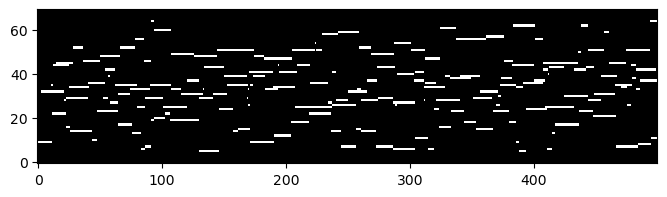

In [76]:
pr = pt.utils.compute_pianoroll(p)
fig, ax = plt.subplots(1, figsize=(8, 2))
ax.imshow(pr.toarray()[15:85,:500], origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
plt.show()

In [77]:
SAMPLE_RATE = 11025

audio_p = pt.utils.synth.synthesize(note_info=p, samplerate=SAMPLE_RATE, harmonic_dist=10, bpm=180)
ipd.display(ipd.Audio(data=audio_p, rate=SAMPLE_RATE, normalize=False))

## 4. Extracting Information from Scores and Performances

For many MIR tasks we need to extract specific information out of scores or performances. 
Two of the most common representations are **note arrays** and **piano rolls**. 

**Note that there is some overlap in the way that these terms are used.**

Partitura provides convenience methods to extract these common features in a few lines!

### 4.1 Note Arrays

A **note array** is a 2D array in which each row represents a note in the score/performance and each column represents different attributes of the note.

In partitura, note arrays are [structured numpy arrays](https://numpy.org/devdocs/user/basics.rec.html), which are ndarrays in which each "column" has a name, and can be of different datatypes. 
This allows us to hold information that can be represented as integers (MIDI pitch/velocity), floating point numbers (e.g., onset time) or strings (e.g., note ids). 

In this tutorial we are going to cover 3 main cases

* Getting a note array from `Part` and `PerformedPart` objects
* Extra information and alternative ways to generate a note array
* Creating a custom note array from scratch from a `Part` object


#### 4.1.1. Getting a note array from `Part` and `PerformedPart` objects

##### Getting a note array from `Part`  or  `Score`  objects

In [78]:
# Note array from a score

# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op38.musicxml')

# Load the score into a `Score` object
score = pt.load_musicxml(score_fn)

# Get note array. Calling note arrays from scores will merge the contained parts' note arrays into one.
score_note_array = score.note_array() 

It is that easy!

In [79]:
# Lets see the first notes in this note array
print(score_note_array[:10])

[(-4., 1., -2. , 0.5,  0,  8, 60, 4, 'n2', 16)
 (-4., 1., -2. , 0.5,  0,  8, 72, 1, 'n1', 16)
 (-3., 2., -1.5, 1. ,  8, 16, 60, 4, 'n4', 16)
 (-3., 2., -1.5, 1. ,  8, 16, 72, 1, 'n3', 16)
 (-1., 1., -0.5, 0.5, 24,  8, 60, 4, 'n6', 16)
 (-1., 1., -0.5, 0.5, 24,  8, 72, 1, 'n5', 16)
 ( 0., 2.,  0. , 1. , 32, 16, 60, 4, 'n8', 16)
 ( 0., 2.,  0. , 1. , 32, 16, 72, 1, 'n7', 16)
 ( 2., 1.,  1. , 0.5, 48,  8, 60, 4, 'n10', 16)
 ( 2., 1.,  1. , 0.5, 48,  8, 72, 1, 'n9', 16)]


![example_note_array-2.png](https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_note_array.png)

By default, Partitura includes some of the most common note-level information in the note array:

In [80]:
print(score_note_array.dtype.names)

('onset_beat', 'duration_beat', 'onset_quarter', 'duration_quarter', 'onset_div', 'duration_div', 'pitch', 'voice', 'id', 'divs_pq')


* `onset_beat` is the onset time in beats (as indicated by the time signature). In partitura, negative onset times in beats represent pickup measures. Onset time 0 is the start of the first measure.
* `duration_beat` is the duration of the note in beats
* `onset_quarter` is the onset time of the note in quarters (independent of the time signature). Similarly to onset time in beats, negative onset times in quarters represent pickup measures and onset time 0 is the start of the first measure.
* `duration_quarter`is the duration of the note in quarters
* `onset_div` is the onset of the note in *divs*, which is generally a number that allows to represent the note position and duration losslessly with integers. In contrast to onset time in beats or quarters, onset time in divs always start at 0 at the first "element" in the score (which might not necessarily be a note).
* `duration_div` is the duration of the note in divs.
* `pitch` is the MIDI pitch (MIDI note number) of the note
* `voice` is the voice of the note (in polyphonic music, where there can be multiple notes at the same time)
* `id` is the note id (as appears in MusicXML or MEI formats)

##### Getting a note array from a  `PerformedPart`

In a similar way, we can obtain a note array from a MIDI file in a few lines

In [81]:
# Note array from a performance

# Path to the MIDI file
performance_fn = os.path.join(MIDI_DIR, 'Chopin_op38_p01.mid')

# Loading the file to a PerformedPart
performance = pt.load_performance_midi(performance_fn)

# Get note array!
performance_note_array = performance.note_array()

c:\users\silva\documents\repos\partitura\partitura\io\importmidi.py:151: UserWarning: change of Tempo to mpq = 500000  and resulting seconds per tick = 0.000125at time: 0.0
  warnings.warn(


Since performances contain have other information not included in scores, the default fields in the note array are a little bit different:

In [82]:
print(performance_note_array.dtype.names)

('onset_sec', 'duration_sec', 'pitch', 'velocity', 'track', 'channel', 'id')


* `onset_sec` is the onset time of the note in seconds. Onset time in seconds is always $\geq 0$ (otherwise, the performance would violate the laws of physics ;)
* `duration_sec` is the duration of the note in seconds
* `pitch` is the MIDI pitch
* `velocity` is the MIDI velocity
* `track` is the track number in the MIDI file
* `channel` is the channel in the MIDI file
* `id` is the ID of the notes (automatically generated for MIDI file according to onset time)

In [83]:
print(performance_note_array[:5])

[(5.6075 , 5.5025 , 72, 37, 0, 0, 'n0')
 (5.63375, 5.47625, 60, 27, 0, 0, 'n1')
 (6.07   , 5.04   , 72, 45, 0, 0, 'n2')
 (6.11125, 4.99875, 60, 26, 0, 0, 'n3')
 (6.82625, 4.28375, 60, 39, 0, 0, 'n4')]


We can also create a `PerformedPart` directly from a note array

In [84]:
note_array = np.array(
    [(60, 0, 2, 40),
     (65, 0, 1, 15),
     (67, 0, 1, 72),
     (69, 1, 1, 90),
     (66, 2, 1, 80)],
    dtype=[("pitch", "i4"),
           ("onset_sec", "f4"),
           ("duration_sec", "f4"),
           ("velocity", "i4"),
          ]
)

# Note array to `PerformedPart`
performed_part = pt.performance.PerformedPart.from_note_array(note_array)

We can then export the `PerformedPart` directly to a MIDI file!

In [85]:
# export as MIDI file
# pt.save_performance_midi(performed_part, "example.mid")

#### 4.1.2. Extra information and alternative ways to generate a note array

Sometimes we require more information in a note array.

In [86]:
extended_score_note_array = pt.utils.music.ensure_notearray(
    score,
    include_pitch_spelling=True, # adds 3 fields: step, alter, octave 
    include_key_signature=True, # adds 2 fields: ks_fifths, ks_mode
    include_time_signature=True, # adds 2 fields: ts_beats, ts_beat_type 
    include_metrical_position=True, # adds 3 fields: is_downbeat, rel_onset_div, tot_measure_div
    include_grace_notes=True # adds 2 fields: is_grace, grace_type
)

In [87]:
extended_score_note_array.dtype.names

('onset_beat',
 'duration_beat',
 'onset_quarter',
 'duration_quarter',
 'onset_div',
 'duration_div',
 'pitch',
 'voice',
 'id',
 'step',
 'alter',
 'octave',
 'is_grace',
 'grace_type',
 'ks_fifths',
 'ks_mode',
 'ts_beats',
 'ts_beat_type',
 'ts_mus_beats',
 'is_downbeat',
 'rel_onset_div',
 'tot_measure_div',
 'divs_pq')

In [88]:
print(extended_score_note_array[['id', 
                                 'step', 
                                 'alter', 
                                 'octave', 
                                 'ks_fifths', 
                                 'ks_mode',
                                 'is_downbeat']][:10])

[('n2', 'C', 0, 4, -1, 1, 0) ('n1', 'C', 0, 5, -1, 1, 0)
 ('n4', 'C', 0, 4, -1, 1, 0) ('n3', 'C', 0, 5, -1, 1, 0)
 ('n6', 'C', 0, 4, -1, 1, 0) ('n5', 'C', 0, 5, -1, 1, 0)
 ('n8', 'C', 0, 4, -1, 1, 1) ('n7', 'C', 0, 5, -1, 1, 1)
 ('n10', 'C', 0, 4, -1, 1, 0) ('n9', 'C', 0, 5, -1, 1, 0)]


[//]:![example_extended_note_array_cof.png](https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_extended_note_array_cof.png)
<div>
<img src="https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_extended_note_array_cof.png" width="500"/>
</div>

#### Extending note arrays with partitura.musicanalysis.note_features

Note arrays can further be extended with note features. Note features are musical attributes that can be retrieved by built-in helper functions. See a list of avaliable note feature functions by calling `partitura.musicanalysis.list_note_feats_functions`. Pass a list of chosen note features to `partitura.compute_note_array` to compute an extended note array. 

In [89]:
pt.musicanalysis.list_note_feats_functions()

['articulation_direction_feature',
 'articulation_feature',
 'duration_feature',
 'fermata_feature',
 'grace_feature',
 'loudness_direction_feature',
 'metrical_feature',
 'metrical_strength_feature',
 'onset_feature',
 'ornament_feature',
 'polynomial_pitch_feature',
 'relative_score_position_feature',
 'slur_feature',
 'staff_feature',
 'tempo_direction_feature',
 'time_signature_feature',
 'vertical_neighbor_feature']

In [90]:
pt.compute_note_array(score, feature_functions=[
 'metrical_feature',
 'metrical_strength_feature'
                      ])[:10]

array([('n1', -4., 1., -2. , 0.5,   0,  8, 72, 1, 1., 0., 0., 0., 0., 0., 0., 0.33333334, 0., 0., 0.),
       ('n10',  2., 1.,  1. , 0.5,  48,  8, 60, 4, 0., 0., 0., 1., 0., 0., 0., 0.33333334, 0., 0., 0.),
       ('n100', 38., 1., 19. , 0.5, 336,  8, 62, 3, 0., 0., 0., 1., 0., 0., 0., 0.33333334, 0., 0., 0.),
       ('n101', 38., 1., 19. , 0.5, 336,  8, 53, 4, 0., 0., 0., 1., 0., 0., 0., 0.33333334, 0., 0., 0.),
       ('n102', 38., 1., 19. , 0.5, 336,  8, 46, 5, 0., 0., 0., 1., 0., 0., 0., 0.33333334, 0., 0., 0.),
       ('n103', 39., 2., 19.5, 1. , 344, 16, 69, 1, 0., 0., 1., 0., 0., 0., 0., 0.5       , 0., 1., 0.),
       ('n104', 39., 2., 19.5, 1. , 344, 16, 60, 3, 0., 0., 1., 0., 0., 0., 0., 0.5       , 0., 1., 0.),
       ('n105', 39., 2., 19.5, 1. , 344, 16, 53, 4, 0., 0., 1., 0., 0., 0., 0., 0.5       , 0., 1., 0.),
       ('n106', 39., 2., 19.5, 1. , 344, 16, 48, 5, 0., 0., 1., 0., 0., 0., 0., 0.5       , 0., 1., 0.),
       ('n107', 41., 1., 20.5, 0.5, 360,  8, 70, 1, 0., 0.

#### 4.1.3. Creating a custom note array from scratch from a `Part` object

Sometimes we are interested in other note-level information that is not included in the standard note features. 
With partitura we can create such a custom note array easily!

For example, imagine that we want a note array that includes whether the notes have an accent mark.

In [91]:
# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')

# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)[0]

def get_accent_note_array(part):
    
    fields = [("onset_beat", "f4"), 
              ("pitch", "i4"),
              ("accent", "i4")]
    # Get all notes in the part
    notes = part.notes_tied
    # Beat map (maps divs to score time in beats)
    beat_map = part.beat_map
    N = len(notes)
    note_array = np.zeros(N, dtype=fields)
    for i, n in enumerate(notes):
        # MIDI pitch
        note_array[i]['pitch'] = n.midi_pitch
        # Get the onset time in beats
        note_array[i]['onset_beat'] = beat_map(n.start.t)
        
        # Iterate over articulations in the note
        if n.articulations:
            for art in n.articulations:
                if art == 'accent':
                    note_array[i]['accent'] = 1
    return note_array

accent_note_array = get_accent_note_array(score_part)

accented_note_idxs = np.where(accent_note_array['accent'])
print(accent_note_array[accented_note_idxs][:5])

[(0.25, 47, 1) (1.25, 47, 1) (2.25, 47, 1) (3.  , 68, 1) (3.25, 47, 1)]


<div>
<img src="https://github.com/CPJKU/partitura_tutorial/raw/main/static/example_note_array_accents.png" width="500"/>
</div>

### 4.2 Piano rolls

Piano rolls are 2D matrices that represent pitch and time information. The time represents time steps (at a given resolution), while the pitch axis represents which notes are active at a given time step. We can think of piano rolls as the symbolic equivalent of spectrograms. 

#### Extracting a piano roll

In [92]:
# TODO: change the example
# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')

# Load the score
score = pt.load_musicxml(score_fn)
# compute piano roll
pianoroll = pt.utils.compute_pianoroll(score)

The `compute_pianoroll` method has a few arguments to customize the resulting piano roll

In [93]:
piano_range = True
time_unit = 'beat'
time_div = 10
pianoroll = pt.utils.compute_pianoroll(
    note_info=score, # a `Score`, `Performance`, `Part`, `PerformedPart` or a note array
    time_unit=time_unit, # beat, quarter, div, sec, etc. (depending on note_info)
    time_div=time_div, # Number of cells per time unit
    piano_range=piano_range # Use range of the piano (88 keys)
)

An important thing to remember is that in piano rolls generated by `compute_pianoroll`, rows (the vertical axis) represent the pitch dimension and the columns (horizontal) the time dimension. 
This results in a more intuitive way of plotting the piano roll. 
For other applications the transposed version of this piano roll might be more useful (i.e., rows representing time steps and columns representing pitch information).

Since piano rolls can result in very large matrices where most of the elements are 0, the output of `compute_pianoroll` is a [scipy sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). To convert it to a regular numpy array, we can simply use `pianoroll.toarray()`

Let's plot the piano roll!

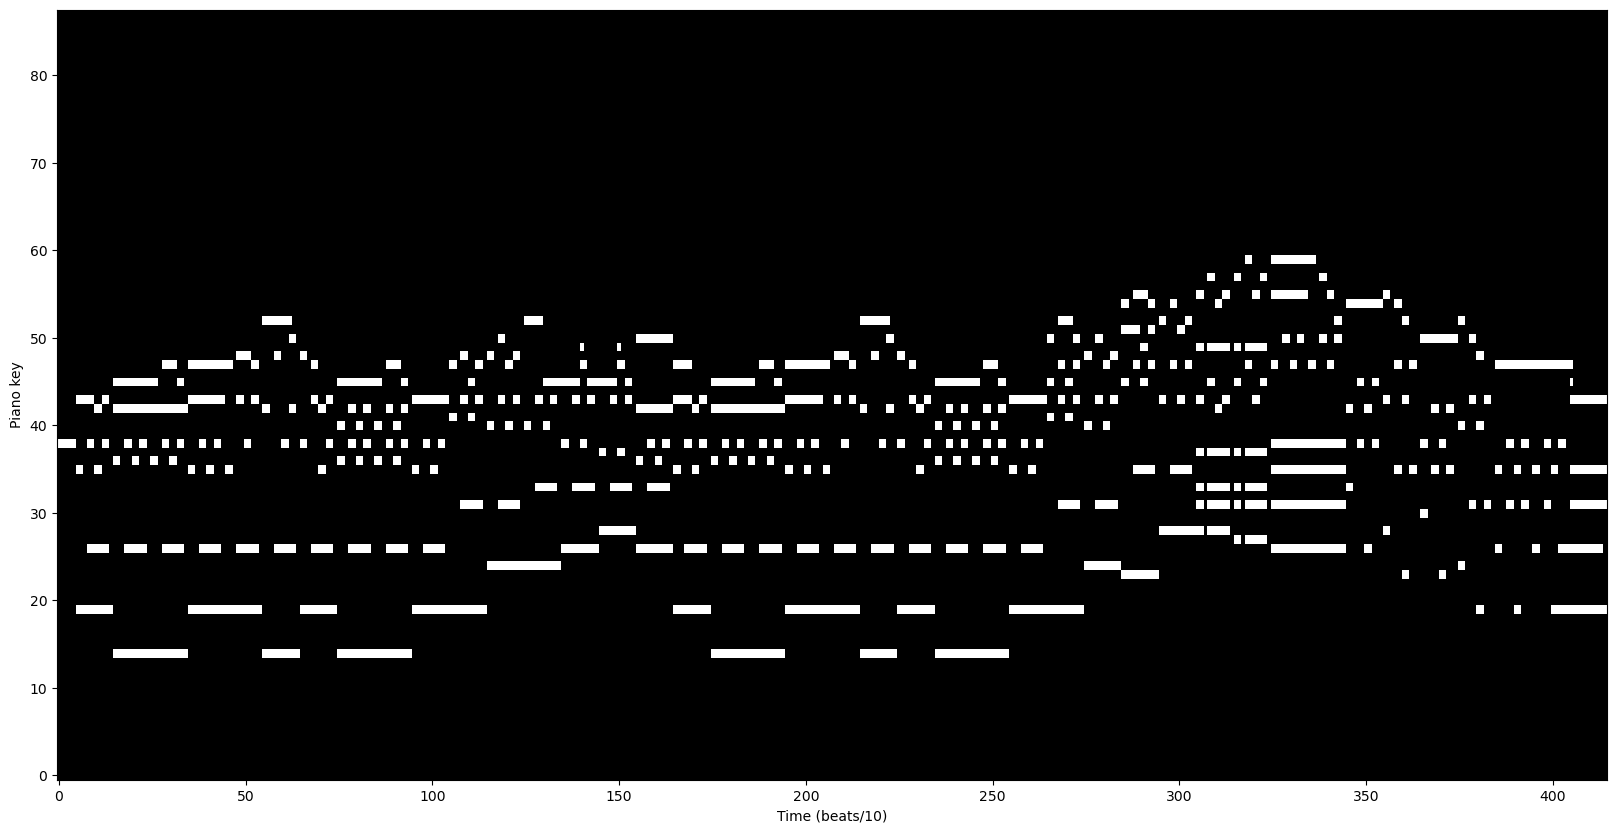

In [94]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(pianoroll.toarray(), origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({time_unit}s/{time_div})')
ax.set_ylabel('Piano key' if piano_range else 'MIDI pitch')
plt.show()

In some cases, we want to know the "coordinates" of each of the notes in the piano roll. The `compute_pianoroll` method includes an option to return 

In [95]:
pianoroll, note_indices = pt.utils.compute_pianoroll(score_part, return_idxs=True)

# MIDI pitch, start, end
print(note_indices[:5])

[[59  0  4]
 [40  4  6]
 [40  4 12]
 [56  4  6]
 [64  4  8]]


#### Generating a note array from a piano roll

Partitura also includes a method to generate a note array from a piano roll, which can be used to generate a MIDI file. 
This method would be useful, e.g., for music generation tasks

In [96]:
pianoroll = pt.utils.compute_pianoroll(score_part)

new_note_array = pt.utils.pianoroll_to_notearray(pianoroll)

# We can export the note array to a MIDI file
ppart = pt.performance.PerformedPart.from_note_array(new_note_array)

# pt.save_performance_midi(ppart, "newmidi.mid")

## 5. Music Analysis

Automatic music analysis is one of the main areas where partitura pipelines are useful. Furthermore, for comparison and non-state-of-the-art applications partitura also provides baseline algorithms for several music analysis tasks:

|Returns| Method|Notes|
|:---|:---|:---|
|Voices | `partitura.musicanalysis.estimate_voices`| Estimate each note's voice |
|Key | `partitura.musicanalysis.estimate_key`| |
|Pitch Spelling |  `partitura.musicanalysis.estimate_spelling`| Infer correct pitch spelling from MIDI pitches|
|Tonal Tension|  `partitura.musicanalysis.estimate_tonaltension`||
|Meter, Beats, Tempo|  `partitura.musicanalysis.estimate_time`||



## The end of the tutorial, the start of your yet untold adventures in symbolic music processing...

Thank you for trying out partitura! We hope it serves you well. 

If you miss a particular functionality or encounter a bug, we appreciate it if you raise an issue on github: https://github.com/CPJKU/partitura/issues